# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_098  P40121;P40121-2   18.032
Sample_191  A0A0G2JRQ6        19.361
Sample_059  Q9NZ08;Q9NZ08-2   14.014
Sample_068  P05546            19.205
Sample_177  Q92854            14.902
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups            
Sample_058  P35754                       14.441
Sample_142  Q6UWR7                       15.762
Sample_006  Q9BU40-2;Q9BU40-4;Q9BU40-5   16.774
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.314
            A0A075B6Q5                 12.785
            A0A075B6R2                 12.837
            A0A075B6S5                 12.834
            A0A087WSY4                 12.096
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.674
            Q9UI40;Q9UI40-2            12.573
            Q9UIW2                     12.824
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.241
            Q9UP79                     13.750
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.201,15.050,16.842,19.863,15.983,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.569,19.067,...,15.528,15.576,14.547,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.013,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.064,17.705,17.039,15.489,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.233,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.609,15.345,17.084,18.708,14.249,19.433,11.350,10.711
Sample_207,15.739,16.877,15.469,16.898,14.333,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.450,12.816,12.073,11.528,12.449,13.078,11.760,12.712,13.553,13.423
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.111,19.067,16.127,...,12.375,12.828,12.481,12.480,11.484,13.396,13.862,12.242,12.891,12.461
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.541,12.763,13.245,12.869,11.945,13.741,11.251,11.837,13.032,12.385
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.445,12.209,12.412,12.251,12.473,14.372,12.154,12.844,12.982,12.924
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.408,13.786,11.830,13.788,14.012,11.638,14.327,12.912,13.048,13.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.172,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 172.72it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.33it/s]

100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.65it/s]

100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.10it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.86it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.91it/s]

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.96it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.86it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.15it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.71it/s]

100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

100%|██████████| 6/6 [00:01<00:00,  4.00it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.97it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.45it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.22it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.52it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.42it/s]

100%|██████████| 7/7 [00:01<00:00,  3.41it/s]

100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.83it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.09it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.64it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.22it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.22it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.14it/s]

100%|██████████| 8/8 [00:01<00:00,  3.37it/s]

100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.68it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.89it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.68it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.75it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.74it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.89it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.78it/s]

100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.04it/s]

 30%|███       | 3/10 [00:00<00:02,  3.40it/s]

 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.14it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.09it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.08it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.06it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.04it/s]

100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.78it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.07it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.20it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.88it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.67it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.41it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.18it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.43it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.83it/s]

100%|██████████| 11/11 [00:01<00:00,  5.97it/s]

100%|██████████| 11/11 [00:01<00:00,  5.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.84it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.87it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.54it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.51it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.07it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.94it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.01it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.10it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.23it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.36it/s]

100%|██████████| 12/12 [00:02<00:00,  4.16it/s]

100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.16it/s]

 31%|███       | 4/13 [00:00<00:01,  5.56it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.85it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.69it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.48it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.67it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.62it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.32it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.89it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.96it/s]

100%|██████████| 13/13 [00:02<00:00,  3.99it/s]

100%|██████████| 13/13 [00:02<00:00,  4.48it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.32it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.62it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.68it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.31it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.28it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.25it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.30it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.96it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.83it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.94it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.06it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.16it/s]

100%|██████████| 14/14 [00:03<00:00,  4.15it/s]

100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.76it/s]

 20%|██        | 3/15 [00:00<00:02,  5.68it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.11it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.83it/s]

 40%|████      | 6/15 [00:01<00:02,  4.42it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.19it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.16it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.02it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.60it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.67it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.66it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.66it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.75it/s]

100%|██████████| 15/15 [00:03<00:00,  3.84it/s]

100%|██████████| 15/15 [00:03<00:00,  4.11it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.050 0.018          0.701 0.395       0.098   
2             0.004 0.001      0.045 0.013          0.675 0.100       0.528   
3             0.004 0.002      0.044 0.015          0.738 0.067       0.708   
4             0.005 0.002      0.062 0.020          0.733 0.065       0.707   
5             0.005 0.002      0.058 0.021          0.776 0.080       0.754   
6             0.004 0.001      0.043 0.012          0.787 0.087       0.766   
7             0.005 0.003      0.052 0.018          0.822 0.079       0.832   
8             0.007 0.003      0.065 0.025          0.819 0.079       0.834   
9             0.007 0.004      0.072 0.032          0.813 0.084       0.826   
10            0.004 0.001      0.036 0.006          0.807 0.088       0.819   
11            0.003 0.001      0.033 0.007          0.812 0.091       0.822   
12            0.004 0.001      0.040 0.007          0.810 0.085       0.822   
13            0.004 0.001      0.039 0.006          0.825 0.084       0.831   
14            0.004 0.001      0.042 0.010          0.824 0.085       0.833   
15            0.004 0.002      0.043 0.011          0.820 0.080       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.166 0.128                  0.542 0.040        0.850   
2          0.105   0.583 0.073                  0.666 0.049        0.731   
3          0.091   0.718 0.061                  0.761 0.049        0.830   
4          0.099   0.715 0.060                  0.758 0.048        0.827   
5          0.097   0.761 0.068                  0.796 0.055        0.845   
6          0.092   0.773 0.074                  0.806 0.062        0.859   
7          0.090   0.824 0.070                  0.850 0.060        0.911   
8          0.090   0.824 0.068                  0.849 0.058        0.911   
9          0.090   0.816 0.069                  0.842 0.060        0.910   
10         0.093   0.810 0.073                  0.836 0.063        0.907   
11         0.090   0.814 0.074                  0.840 0.063        0.909   
12         0.091   0.813 0.071                  0.839 0.061        0.907   
13         0.101   0.825 0.075                  0.850 0.065        0.911   
14         0.102   0.825 0.074                  0.850 0.064        0.910   
15         0.105   0.823 0.075                  0.849 0.065        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.088        210.000 0.000  
2          0.074                  0.669 0.090        210.000 0.000  
3          0.058                  0.781 0.077        210.000 0.000  
4          0.053                  0.766 0.071        210.000 0.000  
5          0.056                  0.812 0.072        210.000 0.000  
6          0.056                  0.832 0.070        210.000 0.000  
7          0.049                  0.900 0.052        210.000 0.000  
8          0.049                  0.901 0.050        210.000 0.000  
9          0.051                  0.896 0.053        210.000 0.000  
10         0.051                  0.894 0.054        210.000 0.000  
11         0.052                  0.897 0.055        210.000 0.000  
12         0.052                  0.895 0.055        210.000 0.000  
13         0.052                  0.896 0.057        210.000 0.000  
14         0.052                  0.895 0.057        210.000 0.000  
15         0.051                  0.894 0.057 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 493.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.18it/s]

100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

100%|██████████| 3/3 [00:00<00:00,  5.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.99it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

100%|██████████| 4/4 [00:00<00:00,  3.78it/s]

100%|██████████| 4/4 [00:00<00:00,  4.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.39it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.15it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.69it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.81it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.67it/s]

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]

100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.71it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.02it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.53it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.01it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.79it/s]

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.41it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.76it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.84it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.44it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.26it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.21it/s]

100%|██████████| 8/8 [00:01<00:00,  4.12it/s]

100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.24it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.70it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.78it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.41it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.34it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  2.85it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.62it/s]

100%|██████████| 9/9 [00:02<00:00,  2.58it/s]

100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.67it/s]

 30%|███       | 3/10 [00:00<00:02,  3.43it/s]

 40%|████      | 4/10 [00:01<00:01,  3.33it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.34it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.51it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.51it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.52it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.10it/s]

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]

100%|██████████| 10/10 [00:03<00:00,  3.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.31it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.66it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.07it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.69it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.90it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.45it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.14it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.00it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.04it/s]

100%|██████████| 11/11 [00:04<00:00,  2.20it/s]

100%|██████████| 11/11 [00:04<00:00,  2.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.03it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.63it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.39it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.44it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.46it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.48it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.49it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.56it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.60it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.58it/s]

100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.91it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.75it/s]

 31%|███       | 4/13 [00:01<00:03,  2.99it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.68it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.50it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.38it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.20it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.07it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.17it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.32it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.57it/s]

100%|██████████| 13/13 [00:05<00:00,  2.71it/s]

100%|██████████| 13/13 [00:05<00:00,  2.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.26it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.53it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.26it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.23it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.03it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.01it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.95it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.04it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.22it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.87it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.69it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.65it/s]

100%|██████████| 14/14 [00:04<00:00,  2.58it/s]

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.55it/s]

 20%|██        | 3/15 [00:00<00:03,  3.21it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.80it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.64it/s]

 40%|████      | 6/15 [00:02<00:03,  2.69it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.79it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.86it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.80it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.85it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.04it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.01it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.16it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.28it/s]

100%|██████████| 15/15 [00:05<00:00,  2.91it/s]

100%|██████████| 15/15 [00:05<00:00,  2.97it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.041 0.006          0.120 0.291       0.014   
2             0.004 0.001      0.041 0.007          0.700 0.100       0.561   
3             0.003 0.001      0.039 0.005          0.791 0.098       0.701   
4             0.003 0.000      0.040 0.005          0.763 0.092       0.722   
5             0.004 0.001      0.045 0.012          0.769 0.093       0.718   
6             0.004 0.002      0.041 0.010          0.778 0.091       0.730   
7             0.003 0.001      0.030 0.006          0.777 0.092       0.724   
8             0.003 0.000      0.034 0.002          0.784 0.095       0.740   
9             0.006 0.003      0.055 0.022          0.799 0.094       0.768   
10            0.007 0.003      0.072 0.028          0.792 0.091       0.783   
11            0.004 0.000      0.038 0.001          0.801 0.082       0.799   
12            0.007 0.004      0.066 0.028          0.800 0.080       0.794   
13            0.005 0.002      0.048 0.016          0.795 0.081       0.791   
14            0.005 0.002      0.051 0.015          0.797 0.078       0.789   
15            0.006 0.003      0.056 0.022          0.790 0.081       0.781   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.024 0.064                  0.503 0.017        0.864   
2          0.119   0.615 0.091                  0.690 0.062        0.769   
3          0.120   0.737 0.091                  0.781 0.070        0.871   
4          0.122   0.736 0.088                  0.778 0.072        0.873   
5          0.120   0.737 0.085                  0.778 0.067        0.873   
6          0.121   0.747 0.084                  0.787 0.067        0.872   
7          0.116   0.744 0.081                  0.784 0.065        0.869   
8          0.119   0.755 0.083                  0.793 0.067        0.871   
9          0.109   0.778 0.078                  0.812 0.065        0.896   
10         0.105   0.782 0.072                  0.814 0.061        0.902   
11         0.116   0.795 0.076                  0.826 0.064        0.909   
12         0.115   0.792 0.076                  0.823 0.064        0.906   
13         0.113   0.788 0.073                  0.820 0.062        0.904   
14         0.104   0.789 0.071                  0.820 0.059        0.912   
15         0.097   0.782 0.071                  0.813 0.061        0.913   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.830 0.087        210.000 0.000  
2          0.073                  0.730 0.084        210.000 0.000  
3          0.059                  0.844 0.075        210.000 0.000  
4          0.057                  0.847 0.070        210.000 0.000  
5          0.058                  0.849 0.070        210.000 0.000  
6          0.057                  0.847 0.070        210.000 0.000  
7          0.058                  0.845 0.071        210.000 0.000  
8          0.059                  0.849 0.073        210.000 0.000  
9          0.054                  0.875 0.068        210.000 0.000  
10         0.053                  0.883 0.064        210.000 0.000  
11         0.047                  0.890 0.057        210.000 0.000  
12         0.049                  0.887 0.058        210.000 0.000  
13         0.049                  0.884 0.058        210.000 0.000  
14         0.047                  0.895 0.056        210.000 0.000  
15         0.046                  0.898 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 988.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 21.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 17.14it/s]

100%|██████████| 3/3 [00:00<00:00, 13.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 26.15it/s]

100%|██████████| 4/4 [00:00<00:00, 21.02it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 16.44it/s]

 80%|████████  | 4/5 [00:00<00:00, 11.61it/s]

100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.63it/s]

100%|██████████| 6/6 [00:00<00:00, 16.39it/s]

100%|██████████| 6/6 [00:00<00:00, 17.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.08it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 10.63it/s]

100%|██████████| 7/7 [00:00<00:00, 10.23it/s]

100%|██████████| 7/7 [00:00<00:00, 10.66it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.18it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.07it/s]

100%|██████████| 8/8 [00:00<00:00, 15.67it/s]

100%|██████████| 8/8 [00:00<00:00, 15.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.55it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.99it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.45it/s]

100%|██████████| 9/9 [00:00<00:00,  9.97it/s]

100%|██████████| 9/9 [00:00<00:00, 10.75it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 15.97it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.35it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.30it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.26it/s]

100%|██████████| 10/10 [00:00<00:00, 14.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.95it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.26it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 11.62it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.81it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.14it/s]

100%|██████████| 11/11 [00:01<00:00, 10.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.04it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.74it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.88it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.06it/s]

100%|██████████| 12/12 [00:00<00:00, 13.38it/s]

100%|██████████| 12/12 [00:00<00:00, 14.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.42it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.47it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.87it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.12it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  9.43it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.20it/s]

100%|██████████| 13/13 [00:01<00:00,  8.82it/s]

100%|██████████| 13/13 [00:01<00:00,  9.80it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.48it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.11it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.72it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.63it/s]

 71%|███████▏  | 10/14 [00:00<00:00,  9.62it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.30it/s]

100%|██████████| 14/14 [00:01<00:00, 10.52it/s]

100%|██████████| 14/14 [00:01<00:00, 10.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 28.28it/s]

 40%|████      | 6/15 [00:00<00:00, 19.28it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.62it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.83it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.20it/s]

100%|██████████| 15/15 [00:01<00:00, 10.62it/s]

100%|██████████| 15/15 [00:01<00:00, 12.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.044 0.012          0.000 0.000       0.000   
2             0.005 0.002      0.056 0.022          0.675 0.130       0.495   
3             0.004 0.002      0.045 0.015          0.663 0.101       0.556   
4             0.004 0.002      0.050 0.018          0.675 0.078       0.592   
5             0.005 0.002      0.053 0.022          0.688 0.082       0.629   
6             0.005 0.002      0.053 0.021          0.726 0.085       0.639   
7             0.005 0.002      0.044 0.016          0.724 0.090       0.653   
8             0.004 0.002      0.042 0.015          0.714 0.097       0.651   
9             0.005 0.002      0.059 0.024          0.704 0.078       0.648   
10            0.004 0.002      0.043 0.013          0.716 0.081       0.647   
11            0.006 0.003      0.063 0.025          0.710 0.082       0.642   
12            0.004 0.002      0.040 0.011          0.707 0.083       0.642   
13            0.005 0.002      0.051 0.019          0.705 0.079       0.653   
14            0.004 0.002      0.041 0.013          0.705 0.077       0.659   
15            0.006 0.004      0.056 0.028          0.700 0.076       0.660   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.765   
2          0.111   0.566 0.107                  0.660 0.072        0.754   
3          0.134   0.597 0.103                  0.674 0.072        0.789   
4          0.118   0.625 0.087                  0.692 0.061        0.804   
5          0.106   0.653 0.082                  0.710 0.063        0.810   
6          0.116   0.675 0.090                  0.732 0.067        0.839   
7          0.122   0.681 0.092                  0.735 0.070        0.832   
8          0.119   0.674 0.088                  0.728 0.067        0.836   
9          0.119   0.670 0.087                  0.724 0.066        0.833   
10         0.111   0.675 0.084                  0.730 0.066        0.833   
11         0.117   0.669 0.087                  0.725 0.068        0.831   
12         0.119   0.668 0.090                  0.724 0.071        0.831   
13         0.113   0.673 0.085                  0.726 0.066        0.833   
14         0.120   0.677 0.087                  0.729 0.068        0.830   
15         0.111   0.675 0.082                  0.727 0.065        0.828   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.703 0.084        210.000 0.000  
2          0.073                  0.710 0.086        210.000 0.000  
3          0.073                  0.724 0.096        210.000 0.000  
4          0.064                  0.760 0.079        210.000 0.000  
5          0.063                  0.774 0.075        210.000 0.000  
6          0.056                  0.803 0.067        210.000 0.000  
7          0.057                  0.797 0.067        210.000 0.000  
8          0.056                  0.803 0.069        210.000 0.000  
9          0.055                  0.803 0.065        210.000 0.000  
10         0.055                  0.803 0.065        210.000 0.000  
11         0.056                  0.801 0.063        210.000 0.000  
12         0.056                  0.798 0.064        210.000 0.000  
13         0.054                  0.797 0.064        210.000 0.000  
14         0.054                  0.790 0.068        210.000 0.000  
15         0.054                  0.786 0.069 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,10,11
score_time,9,10,11
test_precision,13,11,6
test_recall,8,11,15
test_f1,14,11,7
test_balanced_accuracy,14,11,7
test_roc_auc,7,15,6
test_average_precision,8,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.26it/s]

 20%|██        | 3/15 [00:00<00:03,  3.37it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.15it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.07it/s]

 40%|████      | 6/15 [00:01<00:02,  3.06it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.25it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.26it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.33it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.40it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.42it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.02it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.91it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.78it/s]

100%|██████████| 15/15 [00:04<00:00,  2.69it/s]

100%|██████████| 15/15 [00:04<00:00,  3.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 14.84it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.17it/s]

100%|██████████| 6/6 [00:00<00:00, 11.10it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.42it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.41it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.14it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.25it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.26it/s]

100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


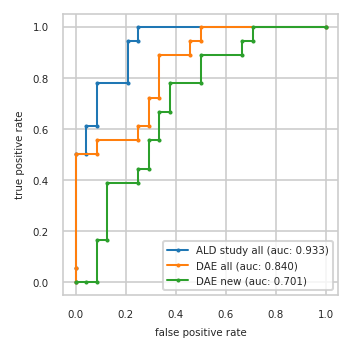

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.500   0.000 0.500   0.083 0.000
3          0.042 0.500   0.083 0.500   0.083 0.167
4          0.042 0.611   0.083 0.556   0.125 0.167
5          0.083 0.611   0.250 0.556   0.125 0.389
6          0.083 0.778   0.250 0.611   0.250 0.389
7          0.208 0.778   0.292 0.611   0.250 0.444
8          0.208 0.944   0.292 0.722   0.292 0.444
9          0.250 0.944   0.333 0.722   0.292 0.556
10         0.250 1.000   0.333 0.889   0.333 0.556
11         1.000 1.000   0.458 0.889   0.333 0.667
12           NaN   NaN   0.458 0.944   0.375 0.667
13           NaN   NaN   0.500 0.944   0.375 0.778
14           NaN   NaN   0.500 1.000   0.500 0.778
15           NaN   NaN   1.000 1.000   0.500 0.889
16           NaN   NaN     NaN   NaN   0.667 0.889
17           NaN   NaN     NaN   NaN   0.667 0.944
18           NaN   NaN     NaN   NaN   0.708 0.944
19           NaN   NaN     NaN   NaN   0.708 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,P22676,E7EPS8;P28827;P28827-2
2,A0A0A0MRJ7;P12259,P31150,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
3,P61981,P04075,P31321
4,P14174,Q9Y2T3;Q9Y2T3-3,P51688
5,P04075,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,Q9Y2T3;Q9Y2T3-3,Q14894,None
7,None,P14174,None
8,None,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


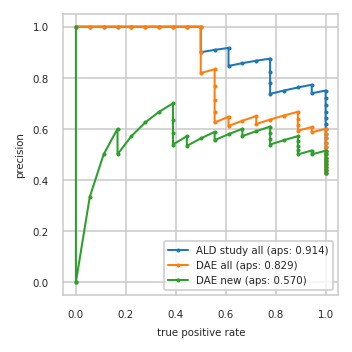

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.667 1.000     0.593 0.889     0.556 0.833
16         0.692 1.000     0.615 0.889     0.538 0.778
17         0.720 1.000     0.640 0.889     0.560 0.778
18         0.750 1.000     0.667 0.889     0.583 0.778
19         0.739 0.944     0.652 0.833     0.609 0.778
20         0.773 0.944     0.636 0.778     0.591 0.722
21         0.762 0.889     0.619 0.722     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.778 0.778     0.611 0.611     0.556 0.556
25         0.824 0.778     0.647 0.611     0.588 0.556
26         0.875 0.778     0.625 0.556     0.562 0.500
27         0.867 0.722     0.667 0.556     0.533 0.444
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.917 0.611     0.833 0.556     0.583 0.389
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.700 0.389
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


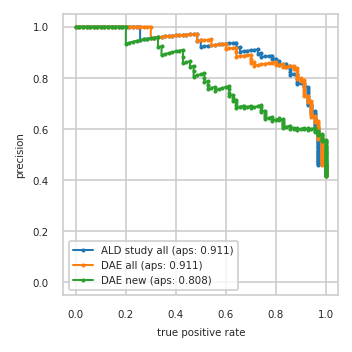

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


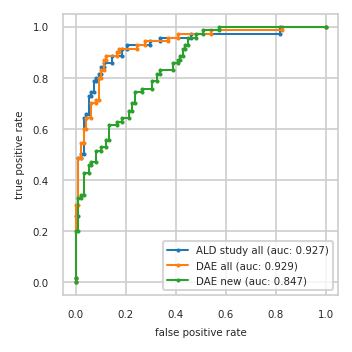

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}